In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond

In [3]:
np.random.seed(0) 

X = np.random.randn(200, 20)   
beta_true = np.random.randn(20) 
noise = 0.1 * np.random.randn(200) 
y = X @ beta_true + noise       

print("Condition number of X:", cond(X))
print("First 5 values of y:", y[:5])


Condition number of X: 1.703051197787162
First 5 values of y: [-2.4307426  -5.49401837  0.93889084 -2.7802066  -8.99570186]


In [4]:
# ordinary least squares solution
XtX = X.T @ X
Xty = X.T @ y
beta_ols = np.linalg.inv(XtX) @ Xty

print("Estimated coefficients (first 5):", beta_ols[:5])
print("True coefficients (first 5):     ", beta_true[:5])


Estimated coefficients (first 5): [ 0.61845122  1.84002526  0.27128582  1.14240681 -1.74462582]
True coefficients (first 5):      [ 0.61334917  1.84369998  0.27109098  1.13644763 -1.73833187]


In [5]:
error = np.linalg.norm(beta_ols - beta_true)
print("Parameter estimation error:", error)


Parameter estimation error: 0.03209770223469925


In [6]:
U, s, Vt = np.linalg.svd(X, full_matrices=False)
s[-1] = 1e-6   # shrink the smallest singular value
X_bad = U @ np.diag(s) @ Vt

beta_ols_bad = np.linalg.inv(X_bad.T @ X_bad) @ (X_bad.T @ y)

error_bad = np.linalg.norm(beta_ols_bad - beta_true)

print("Condition number of X_bad:", cond(X_bad))
print("Parameter estimation error:", error_bad)


Condition number of X_bad: 17148258.60028229
Parameter estimation error: 9160524.241848685


In [7]:
lam = 1.0 

ridge_matrix = X_bad.T @ X_bad + lam * np.eye(X_bad.shape[1])
beta_ridge = np.linalg.inv(ridge_matrix) @ (X_bad.T @ y)

error_ridge = np.linalg.norm(beta_ridge - beta_true)

print("Ridge parameter estimation error:", error_ridge)


Ridge parameter estimation error: 0.9148071866279041


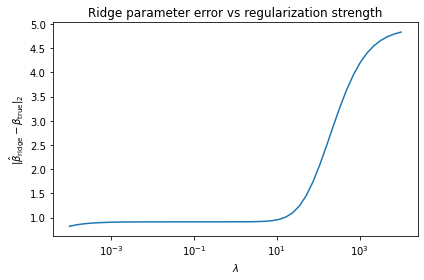

In [8]:
lams = np.logspace(-4, 4, 50)  # 10^-4 to 10^4
errors = []

for lam in lams:
    ridge_matrix = X_bad.T @ X_bad + lam * np.eye(X_bad.shape[1])
    beta_ridge = np.linalg.inv(ridge_matrix) @ (X_bad.T @ y)
    errors.append(np.linalg.norm(beta_ridge - beta_true))

plt.figure(figsize=(6,4))
plt.semilogx(lams, errors)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\|\hat\beta_{\mathrm{ridge}} - \beta_{\mathrm{true}}\|_2$")
plt.title("Ridge parameter error vs regularization strength")
plt.tight_layout()
plt.show()


In [9]:
# generate binary labels for logistic regression
logits = X_bad @ beta_true
probs = 1 / (1 + np.exp(-logits))
y_class = (probs > 0.5).astype(int)

print("Class balance:", np.mean(y_class))


Class balance: 0.47


In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss(beta):
    z = X_bad @ beta
    return -np.mean(y_class * np.log(sigmoid(z)) + (1 - y_class) * np.log(1 - sigmoid(z)))

def logistic_grad(beta):
    z = X_bad @ beta
    return X_bad.T @ (sigmoid(z) - y_class) / len(y_class)

beta_log = np.zeros(X_bad.shape[1])
alpha = 0.01  # learning rate

for _ in range(2000):
    beta_log -= alpha * logistic_grad(beta_log)

print("Estimated logistic coefficients (first 5):", beta_log[:5])
print("True coefficients (first 5):             ", beta_true[:5])


Estimated logistic coefficients (first 5): [ 0.46003762  0.82964967  0.02847741  0.74061227 -0.73809217]
True coefficients (first 5):              [ 0.61334917  1.84369998  0.27109098  1.13644763 -1.73833187]


In [11]:
err_log = np.linalg.norm(beta_log - beta_true)
print("Logistic parameter estimation error:", err_log)


Logistic parameter estimation error: 2.5816742881616195


In [12]:
def logistic_loss_l2(beta, lam):
    z = X_bad @ beta
    data_term = -np.mean(y_class * np.log(sigmoid(z)) + (1 - y_class) * np.log(1 - sigmoid(z)))
    reg_term = 0.5 * lam * np.linalg.norm(beta)**2
    return data_term + reg_term

def logistic_grad_l2(beta, lam):
    z = X_bad @ beta
    grad_data = X_bad.T @ (sigmoid(z) - y_class) / len(y_class)
    grad_reg = lam * beta
    return grad_data + grad_reg

lam = 1.0
beta_log_ridge = np.zeros(X_bad.shape[1])
alpha = 0.01

for _ in range(2000):
    beta_log_ridge -= alpha * logistic_grad_l2(beta_log_ridge, lam)

err_log_ridge = np.linalg.norm(beta_log_ridge - beta_true)
print("Unregularized logistic error:", err_log)
print("L2-regularized logistic error:", err_log_ridge)


Unregularized logistic error: 2.5816742881616195
L2-regularized logistic error: 4.622067467580293


/var/folders/g3/7g_d3dz966184y1rqc50kjmw0000gn/T/ipykernel_3243/2642571296.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/g3/7g_d3dz966184y1rqc50kjmw0000gn/T/ipykernel_3243/592643987.py:10: RuntimeWarning: overflow encountered in multiply
  grad_reg = lam * beta
/var/folders/g3/7g_d3dz966184y1rqc50kjmw0000gn/T/ipykernel_3243/592643987.py:8: RuntimeWarning: invalid value encountered in matmul
  z = X_bad @ beta
/var/folders/g3/7g_d3dz966184y1rqc50kjmw0000gn/T/ipykernel_3243/2261163218.py:8: RuntimeWarning: invalid value encountered in subtract
  beta_tmp -= alpha * logistic_grad_l2(beta_tmp, lam)


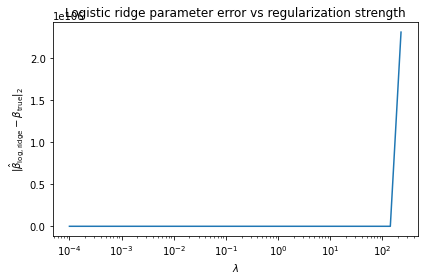

In [13]:
lams = np.logspace(-4, 4, 40)
errs_unreg = []
errs_reg = []

for lam in lams:
    beta_tmp = np.zeros(X_bad.shape[1])
    for _ in range(1000):
        beta_tmp -= alpha * logistic_grad_l2(beta_tmp, lam)
    errs_reg.append(np.linalg.norm(beta_tmp - beta_true))

plt.figure(figsize=(6,4))
plt.semilogx(lams, errs_reg)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\|\hat\beta_{\mathrm{log, ridge}} - \beta_{\mathrm{true}}\|_2$")
plt.title("Logistic ridge parameter error vs regularization strength")
plt.tight_layout()
plt.show()


In [14]:
def accuracy(Xmat, beta, y_labels):
    preds = (sigmoid(Xmat @ beta) > 0.5).astype(int)
    return np.mean(preds == y_labels)

acc_unreg = accuracy(X_bad, beta_log, y_class)
acc_reg = accuracy(X_bad, beta_log_ridge, y_class)

print("Accuracy unregularized:", acc_unreg)
print("Accuracy regularized:", acc_reg)


Accuracy unregularized: 0.97
Accuracy regularized: 0.935


In [15]:
epsilon = 0.05
DeltaX = epsilon * np.random.randn(*X_bad.shape)
X_pert = X_bad + DeltaX

acc_unreg_pert = accuracy(X_pert, beta_log, y_class)
acc_reg_pert = accuracy(X_pert, beta_log_ridge, y_class)

print("Accuracy unregularized on perturbed X:", acc_unreg_pert)
print("Accuracy regularized on perturbed X:", acc_reg_pert)


Accuracy unregularized on perturbed X: 0.97
Accuracy regularized on perturbed X: 0.945
